In [2]:
from typing import List
from scipy.constants import pi, c, epsilon_0, hbar
from qutip import (
    Qobj,
    basis,
    tensor,
    spin_Jx,
    spin_Jy,
    spin_Jz,
    qeye,
)
import numpy as np
from sympy.physics.wigner import wigner_3j, wigner_6j, clebsch_gordan


# We set hbar = 1
A_S = 3.417341305452145e09 * 2 * pi  # Hz
A_P12 = 407.25e6 * 2 * pi
A_P32 = 84.7185e6 * 2 * pi
B_P32 = 12.4965e6 * 2 * pi
MU_BOHR = 2 * pi * 1.399624604e6  # Hz / G
I = 3 / 2  # Rb87


def K_factor(F, J):
    return F * (F + 1) - I * (I + 1) - J * (J + 1)


def Eg(F):
    Jg = 1 / 2
    return 1 / 2 * A_S * K_factor(F, Jg)


def Delta_E_P12(F):
    Je = 1 / 2
    return 1 / 2 * A_P12 * K_factor(F, Je)


def Delta_E_P32(F):
    Je = 3 / 2
    K = K_factor(F, Je)
    return 1 / 2 * A_P32 * K + B_P32 * (
        3 / 2 * K * (K + 1) - 2 * I * (I + 1) * Je * (Je + 1)
    ) / (4 * I * (2 * I - 1) * Je * (2 * Je - 1))


def basic_ket_Fg(F, mF) -> Qobj:
    assert F in (1, 2)
    assert abs(mF) <= F
    if F == 1:
        return basis(8, mF + F)
    elif F == 2:
        return basis(8, mF + F + 3)
    else:
        raise ValueError


def ket_Fg_D1(F, mF) -> Qobj:
    return Qobj(
        np.concatenate((basic_ket_Fg(F, mF).full().flatten(), np.zeros(8, dtype=np.cdouble)))
    )


def ket_Fg_D2(F, mF) -> Qobj:
    return Qobj(
        np.concatenate((basic_ket_Fg(F, mF).full().flatten(), np.zeros(16, dtype=np.cdouble)))
    )


def basic_ket_Fe_D1(F, mF) -> Qobj:
    assert F in (1, 2)
    assert abs(mF) <= F
    if F == 1:
        return basis(8, mF + F)
    elif F == 2:
        return basis(8, mF + F + 3)
    else:
        raise ValueError


def basic_ket_Fe_D2(F, mF) -> Qobj:
    assert F in (0, 1, 2, 3)
    assert abs(mF) <= F
    if F == 0:
        return basis(16, 0)
    elif F == 1:
        return basis(16, mF + F + 1)
    elif F == 2:
        return basis(16, mF + F + 4)
    elif F == 3:
        return basis(16, mF + F + 9)
    else:
        raise ValueError


def ket_Fe_D2(F, mF) -> Qobj:
    return Qobj(
        np.concatenate(
            (np.zeros(8, dtype=np.cdouble), basic_ket_Fe_D2(F, mF).full().flatten())
        )
    )


def ket_Fe_D1(F, mF) -> Qobj:
    return Qobj(
        np.concatenate(
            (np.zeros(8, dtype=np.cdouble), basic_ket_Fe_D1(F, mF).full().flatten())
        )
    )


def H_atom(det_Light, line: str) -> Qobj:
    sum_Fg = sum(
        [Eg(f) * basic_ket_Fg(f, m).proj() for f in (1, 2) for m in range(-f, f + 1)]
    )
    if line == "D1":
        h = np.zeros(shape=(16, 16), dtype=np.cdouble)
        sum_Fe_D1 = sum(
            [
                (Delta_E_P12(f) - det_Light) * basic_ket_Fe_D1(f, m).proj()
                for f in (1, 2)
                for m in range(-f, f + 1)
            ]
        )
        h[:8, :8] = sum_Fg
        h[8:, 8:] = sum_Fe_D1
        return Qobj(h)
    elif line == "D2":
        h = np.zeros(shape=(24, 24), dtype=np.cdouble)
        sum_Fe_D2 = sum(
            [
                (Delta_E_P32(f) - det_Light) * basic_ket_Fe_D2(f, m).proj()
                for f in (0, 1, 2, 3)
                for m in range(-f, f + 1)
            ]
        )
        h[:8, :8] = sum_Fg
        h[8:, 8:] = sum_Fe_D2
        return Qobj(h)
    else:
        raise ValueError


def sigma_q(q: int, line: str) -> Qobj:
    """ "weighted lowering operator", m_F = m'_F + q"""
    assert q in (-1, 0, 1)
    assert line in ("D1", "D2")
    Jg = 1 / 2
    if line == "D1":
        Je = 1 / 2
        opers = []
        op = np.zeros(shape=(16, 16), dtype=np.cdouble)
        for Fg in (1, 2):
            for mg in range(-Fg, Fg + 1):
                for Fe in (1, 2):
                    for me in range(-Fe, Fe + 1):
                        weight = (
                            (-1) ** (Fe + Jg + 1 + I)
                            * ((2 * Fe + 1) * (2 * Jg + 1)) ** (1 / 2)
                            * (-1) ** (-Fe + 1 - mg)
                            * (2 * Fg + 1) ** (1 / 2)
                            * float(wigner_3j(Fe, 1, Fg, me, q, -mg))
                            * float(wigner_6j(Je, Jg, 1, Fg, Fe, I))
                        )
                        lowering_operator = basic_ket_Fg(Fg, mg) * basic_ket_Fe_D1(Fe, me).dag()
                        op[:8, 8:] = weight * lowering_operator
                        opers.append(Qobj(op))
        return sum(opers)
    elif line == "D2":
        Je = 3 / 2
        opers = []
        op = np.zeros(shape=(24, 24), dtype=np.cdouble)
        for Fg in (1, 2):
            for mg in range(-Fg, Fg + 1):
                for Fe in (0, 1, 2, 3):
                    for me in range(-Fe, Fe + 1):
                        weight = (
                            (-1) ** (Fe + Jg + 1 + I)
                            * ((2 * Fe + 1) * (2 * Jg + 1)) ** (1 / 2)
                            * (-1) ** (Fe - 1 + mg)
                            * (2 * Fg + 1) ** (1 / 2)
                            * float(wigner_3j(Fe, 1, Fg, me, q, -mg))
                            * float(wigner_6j(Je, Jg, 1, Fg, Fe, I))
                        )
                        lowering_operator = basic_ket_Fg(Fg, mg) * basic_ket_Fe_D2(Fe, me).dag()
                        op[:8, 8:] = weight * lowering_operator
                        opers.append(Qobj(op))
        return sum(opers)
    else:
        raise ValueError


def E_0_plus(intensity):
    # we assume pure polarization and either sigma plus or minus or linearly pol
    return (2 * intensity / (c * epsilon_0)) ** (1 / 2) / 2


def calculate_beam_intensity(power, waist):
    return power / (pi * waist**2)

def rabi_D1_vector_component(E_field_component):
    dipole = 2.5377e-29  # dipole transition matrix element
    return 2 * dipole * E_field_component / hbar


def rabi_D2_vector_component(E_field_component):
    dipole = 3.58424e-29  # dipole transition matrix element
    return 2 * dipole * E_field_component / hbar


def H_atom_field_D1(q, E_field_component) -> Qobj:
    tmp = (
        1
        / 2
        * np.conjugate(rabi_D1_vector_component(E_field_component))
        * sigma_q(q, "D1")
    )
    return tmp + tmp.dag()


def H_atom_field_D2(q, E_field_component) -> Qobj:
    tmp = (
        1
        / 2
        * np.conjugate(rabi_D2_vector_component(E_field_component))
        * sigma_q(q, "D2")
    )
    return tmp + tmp.dag()


def H_hfs_ground() -> Qobj:
    """in uncoupled basis: I, J=S"""
    return A_S * (
        tensor(spin_Jz(3 / 2), spin_Jz(1 / 2))  # I * J (S_1/2, where L=0)
        + tensor(spin_Jy(3 / 2), spin_Jy(1 / 2))
        + tensor(spin_Jx(3 / 2), spin_Jx(1 / 2))
    )


def H_hfs_excited_D2() -> Qobj:
    """in uncoupled basis !"""
    I_times_J = (
        tensor(spin_Jz(3 / 2), spin_Jz(3 / 2))
        + tensor(spin_Jy(3 / 2), spin_Jy(3 / 2))
        + tensor(spin_Jx(3 / 2), spin_Jx(3 / 2))
    )
    return A_P32 * I_times_J + B_P32 * (
        (
            3 * I_times_J * I_times_J
            + 3 / 2 * I_times_J
            - 3 / 2 * (5 / 2) * 3 / 2 * 5 / 2
        )
        / (2 * 3 / 2 * (3 - 1) * 3 / 2 * (3 - 1))
    )


def H_B_ground_uncoupled(bx=0, by=0, bz=0) -> Qobj:
    """
    In Gauss
    in uncoupled basis of I, S (L=0)
    returns Qobj with dimensions [4, 2]
    """
    return (
        2.0023193043622
        * (  #        I           S
            tensor(qeye(4), spin_Jx(1 / 2)) * bx
            + tensor(qeye(4), spin_Jy(1 / 2)) * by
            + tensor(qeye(4), spin_Jz(1 / 2)) * bz
        )
        - 0.000995
        * (
            tensor(spin_Jx(3 / 2), qeye(2)) * bx
            + tensor(spin_Jy(3 / 2), qeye(2)) * by
            + tensor(spin_Jz(3 / 2), qeye(2)) * bz
        )
    ) * MU_BOHR


def H_B_excited_uncoupled(bx=0, by=0, bz=0) -> Qobj:  # L=1, in G
    """
    L=1, in G
    in uncoupled basis of I, S, L with dimension 4*2*3 = 24.
    D1 and D2 excited state manifolds
    """
    return (
        2.0023193043622
        * (  #        I           S           L
            tensor(qeye(4), spin_Jx(1 / 2), qeye(3)) * bx
            + tensor(qeye(4), spin_Jy(1 / 2), qeye(3)) * by
            + tensor(qeye(4), spin_Jz(1 / 2), qeye(3)) * bz
        )
        - 0.000995
        * (
            tensor(spin_Jx(3 / 2), qeye(2), qeye(3)) * bx
            + tensor(spin_Jy(3 / 2), qeye(2), qeye(3)) * by
            + tensor(spin_Jz(3 / 2), qeye(2), qeye(3)) * bz
        )
        + 0.99999369
        * (
            tensor(qeye(4), qeye(2), spin_Jx(1)) * bx
            + tensor(qeye(4), qeye(2), spin_Jy(1)) * by
            + tensor(qeye(4), qeye(2), spin_Jz(1)) * bz
        )
    ) * MU_BOHR


def Fp_kets_in_I_J_basis() -> List:
    """
    returns list of  state (F, m) kets.
    The ket vectors are of length .
    """
    coupled = []
    for J in (1 / 2, 3 / 2):
        for j in np.arange(-J, J + 1):
            coup_vec = sum(
                [
                    float(clebsch_gordan(1 / 2, 1, J, s, l, j))
                    * tensor(basis(2, int(s + 1 / 2)), basis(3, l + 1))
                    for l in (-1, 0, 1)
                    for s in (-1 / 2, 1 / 2)
                ]
            )
            coupled.append(coup_vec)
    return coupled


def F_kets_in_I_S_L_basis():
    """
    Returns all 8 ground-state F kets (L=0).
    Dimensions:
    """
    fm_states = []
    S = 1 / 2  # = J
    for f in np.arange(3 / 2 - S, 3 / 2 + S + 1):
        for m in np.arange(-f, f + 1):
            fm_state = sum(
                [
                    float(clebsch_gordan(3 / 2, S, f, i, s, m))
                    * tensor(basis(4, int(i + 3 / 2)), basis(2, int(s + 1 / 2)))
                    for s in (-1 / 2, 1 / 2)
                    for i in np.arange(-3 / 2, 3 / 2 + 1)
                ]
            )
            fm_states.append(fm_state)
    return fm_states


def Fp_kets_in_I_S_L_basis():
    """
    Returns all 24 excited-state F kets (J=1/2 D1 and J=3/2 D2).
    Dimensions:  [[4, 2, 3], [1, 1, 1]]
    """
    fm_states = []
    for J in (1 / 2, 3 / 2):
        for f in np.arange(3 / 2 - J, 3 / 2 + J + 1):
            for m in np.arange(-f, f + 1):
                fm_state = sum(
                    [
                        float(clebsch_gordan(3 / 2, J, f, i, j, m))
                        * float(clebsch_gordan(1 / 2, 1, J, s, l, j))
                        * tensor(
                            basis(4, int(i + 3 / 2)),
                            basis(2, int(s + 1 / 2)),
                            basis(3, l + 1),
                        )
                        for l in (-1, 0, 1)
                        for s in (-1 / 2, 1 / 2)
                        for i in np.arange(-3 / 2, 3 / 2 + 1)
                        for j in np.arange(-J, J + 1)
                    ]
                )
                fm_states.append(fm_state)
    return fm_states


def H_B(line: str, bx=0, by=0, bz=0):
    hg = H_B_ground_uncoupled(bx=bx, by=by, bz=bz).transform(F_kets_in_I_S_L_basis())
    he = H_B_excited_uncoupled(bx=bx, by=by, bz=bz).transform(Fp_kets_in_I_S_L_basis())
    if line == "D1":
        tmp = np.zeros((16, 16), dtype=np.cdouble)
        tmp[:8, :8] = hg.full()
        tmp[8:, 8:] = he.full()[:8, :8]
        return Qobj(tmp)
    elif line == "D2":
        tmp = np.zeros((24, 24), dtype=np.cdouble)
        tmp[:8, :8] = hg.full()
        tmp[8:, 8:] = he.full()[8:, 8:]
        return Qobj(tmp)
    else:
        raise ValueError("""Wrong input for 'line'. Use 'D1' or 'D2'""")


GAMMA_RAD_D1 = 5.7500e6 * 2 * pi
GAMMA_RAD_D2 = 6.0666e6 * 2 * pi


def natural_decay_ops_D2():
    return [(2 * GAMMA_RAD_D2) ** (1 / 2) * sigma_q(q, "D2") for q in (-1, 0, 1)]


def natural_decay_ops_D1():
    return [GAMMA_RAD_D1 ** (1 / 2) * sigma_q(q, "D1") for q in [-1, 0, 1]]

In [3]:
from visualizations import *

In [4]:
H_B("D1", bx=1)

Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[       0.         -3120523.80417389        0.         -7628535.38027979
         0.          3114336.52774232        0.                0.
         0.                0.                0.                0.
         0.                0.                0.                0.        ]
 [-3120523.80417389        0.         -3120523.80417389        0.
  -5394189.09791734        0.          5394189.09791734        0.
         0.                0.                0.                0.
         0.                0.                0.                0.        ]
 [       0.         -3120523.80417389        0.                0.
         0.         -3114336.52774232        0.          7628535.38027979
         0.                0.                0.                0.
         0.                0.                0.                0.        ]
 [-7628535.38027979        0.                0.                0.
   4

(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot: title={'center': 'Real'}>,
  <AxesSubplot: title={'center': 'Imag'}>])

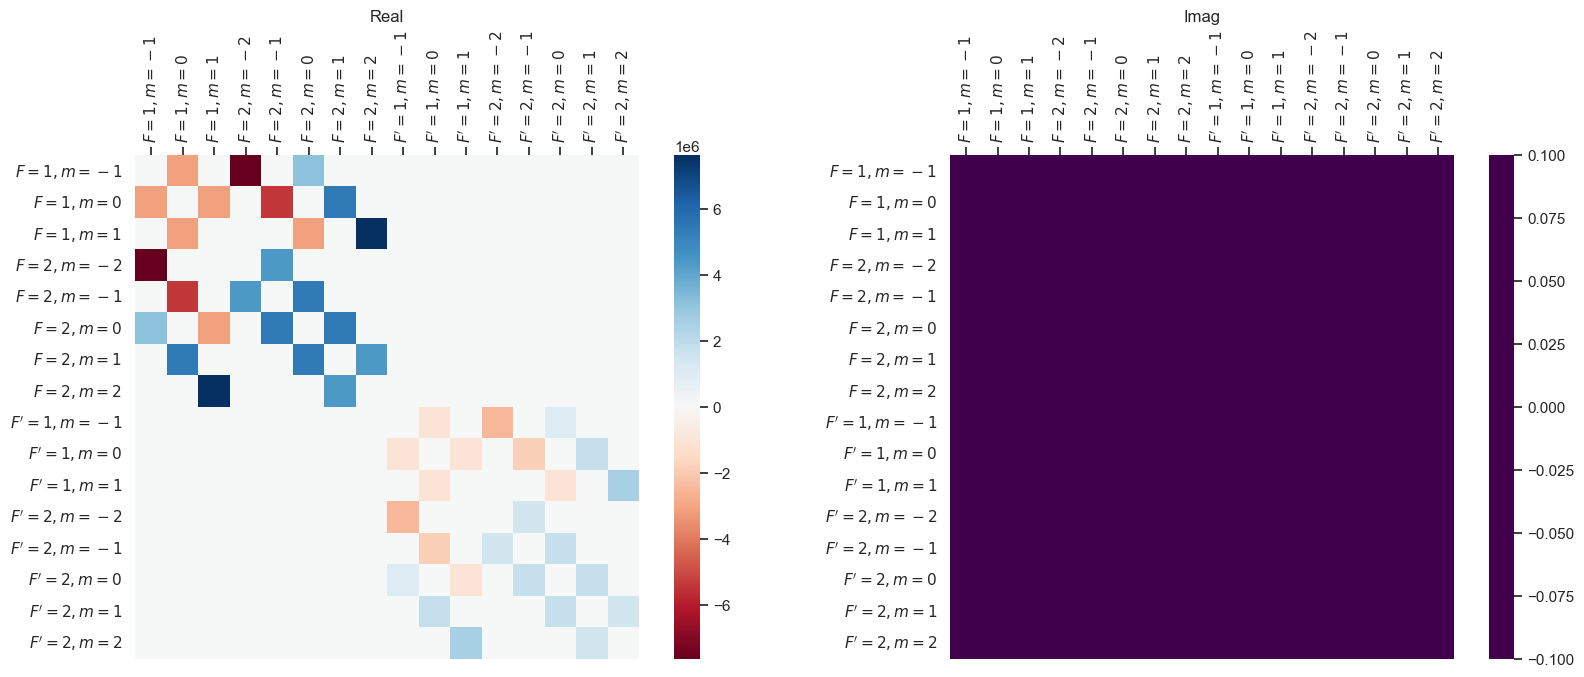

In [5]:
maplot(H_B("D1", bx=1))

(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot: title={'center': 'Real'}>,
  <AxesSubplot: title={'center': 'Imag'}>])

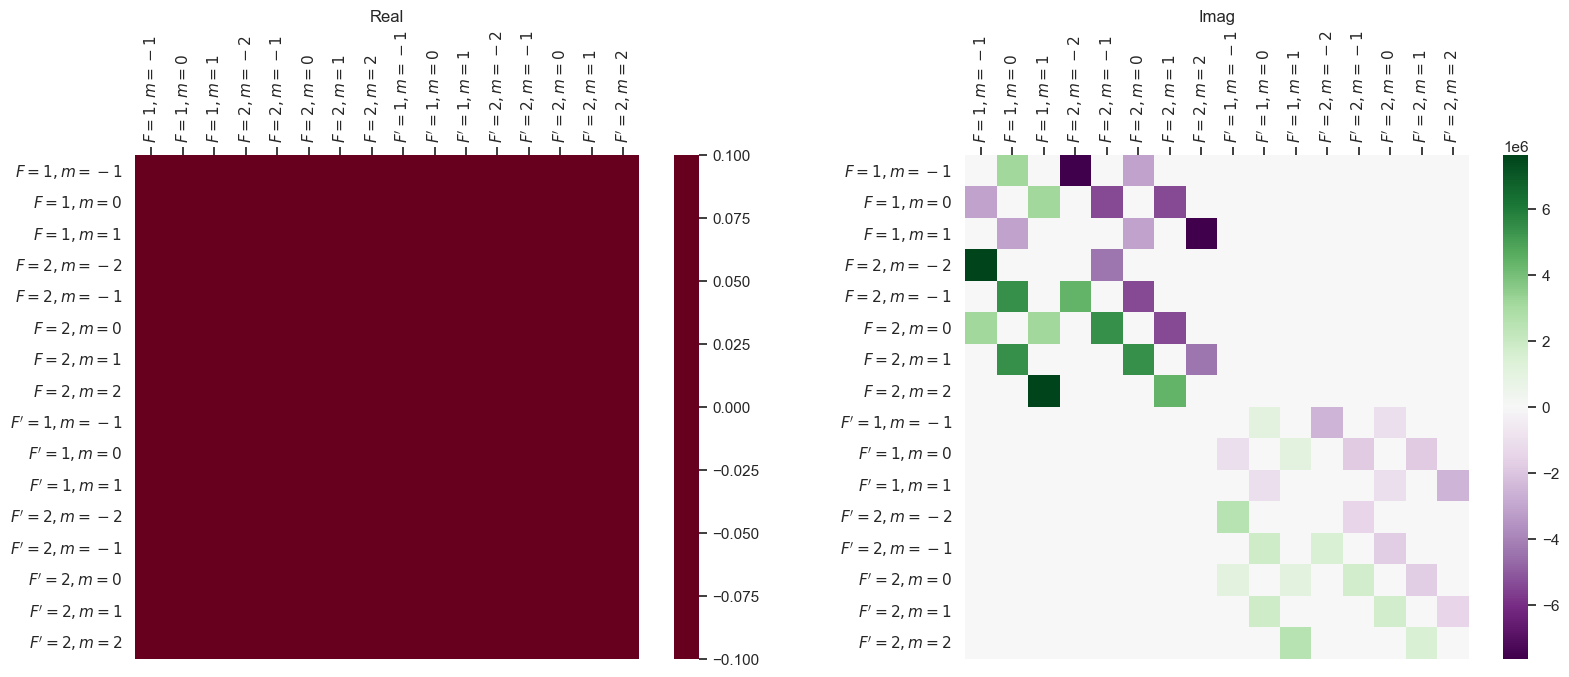

In [6]:
maplot(H_B("D1", by=1))

In [7]:
H_B("D1", by=1)

Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[0.      +0.j         0.+3120523.80417389j 0.      +0.j
  0.-7628535.38027979j 0.      +0.j         0.-3114336.52774232j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j        ]
 [0.-3120523.80417389j 0.      +0.j         0.+3120523.80417389j
  0.      +0.j         0.-5394189.09791734j 0.      +0.j
  0.-5394189.09791734j 0.      +0.j         0.      +0.j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j        ]
 [0.      +0.j         0.-3120523.80417389j 0.      +0.j
  0.      +0.j         0.      +0.j         0.-3114336.52774232j
  0.      +0.j         0.-7628535.38027979j 0.      +0.j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j         0.      +0.j

In [8]:
H_B("D1", by=1)/2/pi

Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[0.      +0.j         0. +496646.7884702j  0.      +0.j
  0.-1214119.11432294j 0.      +0.j         0. -495662.05284184j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j        ]
 [0. -496646.7884702j  0.      +0.j         0. +496646.7884702j
  0.      +0.j         0. -858511.85890596j 0.      +0.j
  0. -858511.85890596j 0.      +0.j         0.      +0.j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j        ]
 [0.      +0.j         0. -496646.7884702j  0.      +0.j
  0.      +0.j         0.      +0.j         0. -495662.05284184j
  0.      +0.j         0.-1214119.11432294j 0.      +0.j
  0.      +0.j         0.      +0.j         0.      +0.j
  0.      +0.j         0.      +0.j 

In [9]:
c

299792458.0

In [10]:
c/((6.834682+0.005)*1e9)

0.04383134449817989

In [11]:
c/((6.834682-0.005)*1e9)

0.04389552222197168

In [12]:
c/((6.834682+0.005)*1e9)-c/((6.834682-0.005)*1e9)

-6.417772379179593e-05

In [13]:
c/((6.834682+0.0005)*1e9)-c/((6.834682-0.0005)*1e9)

-6.417768978833616e-06